#### **Data Processing**

In [148]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Loading in df
df = pd.read_csv("df_ff_factors_100325.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date']) 

# Alpha model training results (all models)
tuned_results = pd.read_csv("tuned_results.csv").drop(columns=["Unnamed: 0"])

tuned_results.head()
tuned_results_tech = pd.read_csv("tech_funds_forecast.csv").drop(columns=["Unnamed: 0"])

tuned_results_tech.head()

,rolling_alpha_5f,ridge,lstm,rf,pca
0,-0.010260,0.011073,0.007853,-0.004025,0.001139
1,-0.001117,0.002080,0.004278,0.001798,0.001844
2,-0.004792,-0.001147,0.004701,-0.001017,0.002882
3,-0.009495,-0.002035,-0.000034,-0.001898,0.001037
4,0.001706,0.001392,0.003908,0.003418,0.003349


Adding Dates To The Results Dataframe

In [151]:
# df_new = df[["crsp_fundno", "date", 'rolling_alpha_5f']]
df_new = df.copy().iloc[int(len(df) * 0.7):]
df_new

,crsp_fundno,date,mth_return,exp_ratio,turn_ratio,normalised_flow,mtna,gdp_to_debt_ratio,gdp_growth_rate,unm_rate,...,smb,hml,rmw,cma,rf,umd,mkt_return,excess_return,rolling_alpha_5f,shortrun_momentum
141398,53069.0,2019-11-29,0.053331,0.0145,0.28,0.064842,244.4,105.782,2.9665,3.6,...,0.0045,-0.0199,-0.0163,-0.0125,0.0012,-0.0264,0.048477,0.052131,-0.003368,-0.002845
7236,6028.0,2019-11-29,0.000626,0.0045,0.86,0.000799,904.4,105.782,2.9665,3.6,...,0.0045,-0.0199,-0.0163,-0.0125,0.0012,-0.0264,0.048477,-0.000574,-0.000574,-0.032550
162278,59337.0,2019-11-29,-0.003521,0.0175,1.70,-1.392993,48.0,105.782,2.9665,3.6,...,0.0045,-0.0199,-0.0163,-0.0125,0.0012,-0.0264,0.048477,-0.004721,-0.006529,-0.027326
86335,27484.0,2019-11-29,0.001600,0.0141,1.56,0.223065,3.8,105.782,2.9665,3.6,...,0.0045,-0.0199,-0.0163,-0.0125,0.0012,-0.0264,0.048477,0.000400,-0.005667,-0.034142
127526,49285.0,2019-11-29,0.023014,0.0095,0.00,0.000000,5.1,105.782,2.9665,3.6,...,0.0045,-0.0199,-0.0163,-0.0125,0.0012,-0.0264,0.048477,0.021814,-0.002250,0.016026
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102347,36888.0,2024-10-31,-0.011755,0.0205,0.38,-0.369789,1.4,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.016455,-0.009595,-0.016542
176070,86513.0,2024-10-31,0.000691,0.0104,0.31,0.046618,549.6,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.004009,-0.001237,-0.011957
182998,95721.0,2024-10-31,-0.020548,0.0078,0.88,-0.080079,0.1,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.025248,0.027648,-0.015228
182760,95714.0,2024-10-31,-0.020782,0.0103,0.88,-0.001780,4.5,120.731,2.5427,4.1,...,-0.0568,-0.0247,0.0066,-0.0102,0.0047,0.0508,0.018446,-0.025482,0.027850,-0.015541


In [152]:
# Combining results df with dates

rolling_alphas = ["rolling_alpha_5f"]
results = [tuned_results]
all_results_healthcare = {}

for i in range(0, len(rolling_alphas)):

    dataset = df_new[["crsp_fundno", "date", 'rolling_alpha_5f']]
    merged_df = pd.merge(results[i], dataset, how="left", on=rolling_alphas[i])
    # merged_df = merged_df.rename(columns={'naive': f'naive_{factor}'})
    
    merged_df_no_id = merged_df.drop(columns=['crsp_fundno'])
    merged_df_no_id = merged_df_no_id.set_index('date')
    feature_cols = [col for col in merged_df_no_id.columns if col not in [rolling_alphas[i]]]

    # Using a dictionary to store the df for different factor models
    all_results_healthcare[rolling_alphas[i]] = merged_df_no_id
all_results_healthcare = all_results_healthcare['rolling_alpha_5f']

In [156]:
all_results_healthcare_clean = all_results_healthcare[all_results_healthcare.index.notna()]
# all_results_healthcare_clean.sort_index()

In [157]:
rolling_alphas = ["rolling_alpha_5f"]
results = [tuned_results_tech]
all_results_tech = {}
df = pd.read_csv("df_ff_factors_techfunds.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date']) 

for i in range(0, len(rolling_alphas)):
    factor = rolling_alphas[i][-2:]

    dataset = df[["crsp_fundno", "date", rolling_alphas[i]]]
    merged_df = pd.merge(results[i], dataset, how="left", on=rolling_alphas[i])
    # merged_df = merged_df.rename(columns={'naive': f'naive_{factor}'})
    
    merged_df_no_id = merged_df.drop(columns=['crsp_fundno'])
    merged_df_no_id = merged_df_no_id.set_index('date')
    feature_cols = [col for col in merged_df_no_id.columns if col not in [rolling_alphas[i]]]

    # Using a dictionary to store the df for different factor models
    all_results_tech[rolling_alphas[i]] = merged_df_no_id
all_results_tech = all_results_tech['rolling_alpha_5f']

Functions for Calculating Metrics & Plotting

In [158]:
# Generation of Error Metrics
def mean_absolute_scaled_error(y_true, y_pred):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    naive_mae = np.mean(np.abs(y_true[1:] - y_true[:-1]))
    mae = mean_absolute_error(y_true, y_pred)
    mase = mae / naive_mae if naive_mae != 0 else np.nan

    return mase 

def metrics_generator(df, metric, outcome_var, relevant_cols):
    if metric == 'MASE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_scaled_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'MAE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_absolute_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    elif metric == 'R2':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: max(r2_score(group[outcome_var], group[col]), -2) for col in relevant_cols
            })
        )
    elif metric == 'MSE':
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: mean_squared_error(group[outcome_var], group[col]) for col in relevant_cols
            })
        )
    else:
        final_df = df.groupby(df.index).apply(
            lambda group: pd.Series({
                col: np.sqrt(mean_squared_error(group[outcome_var], group[col])) for col in relevant_cols
            })
        )
    return final_df


all_metrics_results = {metric: {} for metric in ["MASE", "MAE", "R2", "MSE", "RMSE"]}

models = ['ridge', 'rf', 'lstm', 'pca']
    
rmse_healthcare = metrics_generator(all_results_healthcare_clean, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
rmse_tech = metrics_generator(all_results_tech, metric = "RMSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
# r2 = metrics_generator(all_results, metric = "R2", outcome_var="rolling_alpha_5f", relevant_cols = models)
# mse = metrics_generator(all_results, metric = "MSE", outcome_var="rolling_alpha_5f", relevant_cols = models)
# mae = metrics_generator(all_results, metric = "MAE", outcome_var="rolling_alpha_5f", relevant_cols = models)

#### **Plots**

Plot 1: Metrics Plot by Time

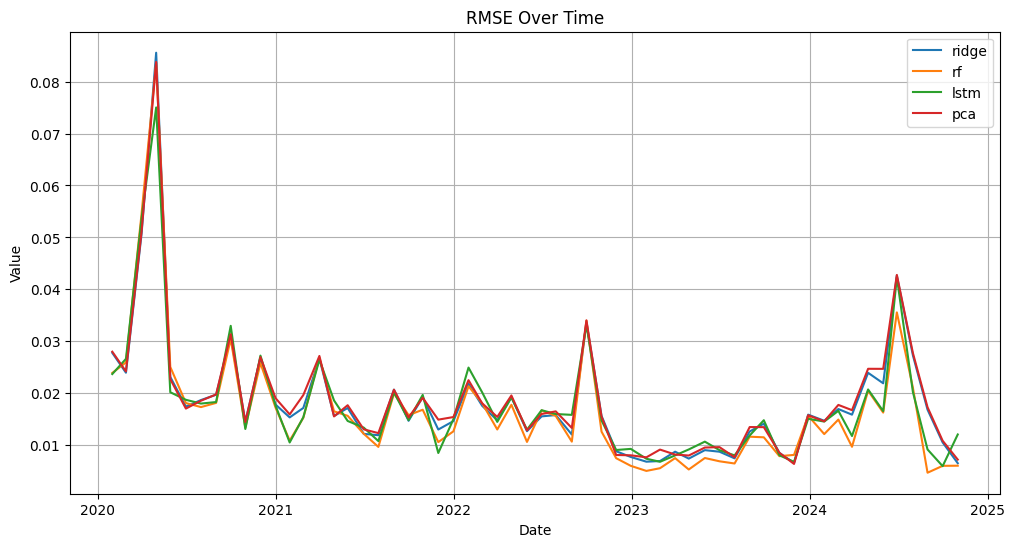

In [161]:
# Single Plot
import pandas as pd
import matplotlib.pyplot as plt

# Load your data (assuming it's already in a DataFrame named df)
rmse_healthcare.index = pd.to_datetime(rmse_healthcare.index)  # Ensure index is datetime

# Plot all models
plt.figure(figsize=(12, 6))
for column in rmse_healthcare.columns:
    plt.plot(rmse_healthcare.index, rmse_healthcare[column], label=column)

# Formatting
plt.xlabel("Date")
plt.ylabel("Value")
plt.title("RMSE Over Time")
plt.legend()
plt.grid(True)
plt.show()

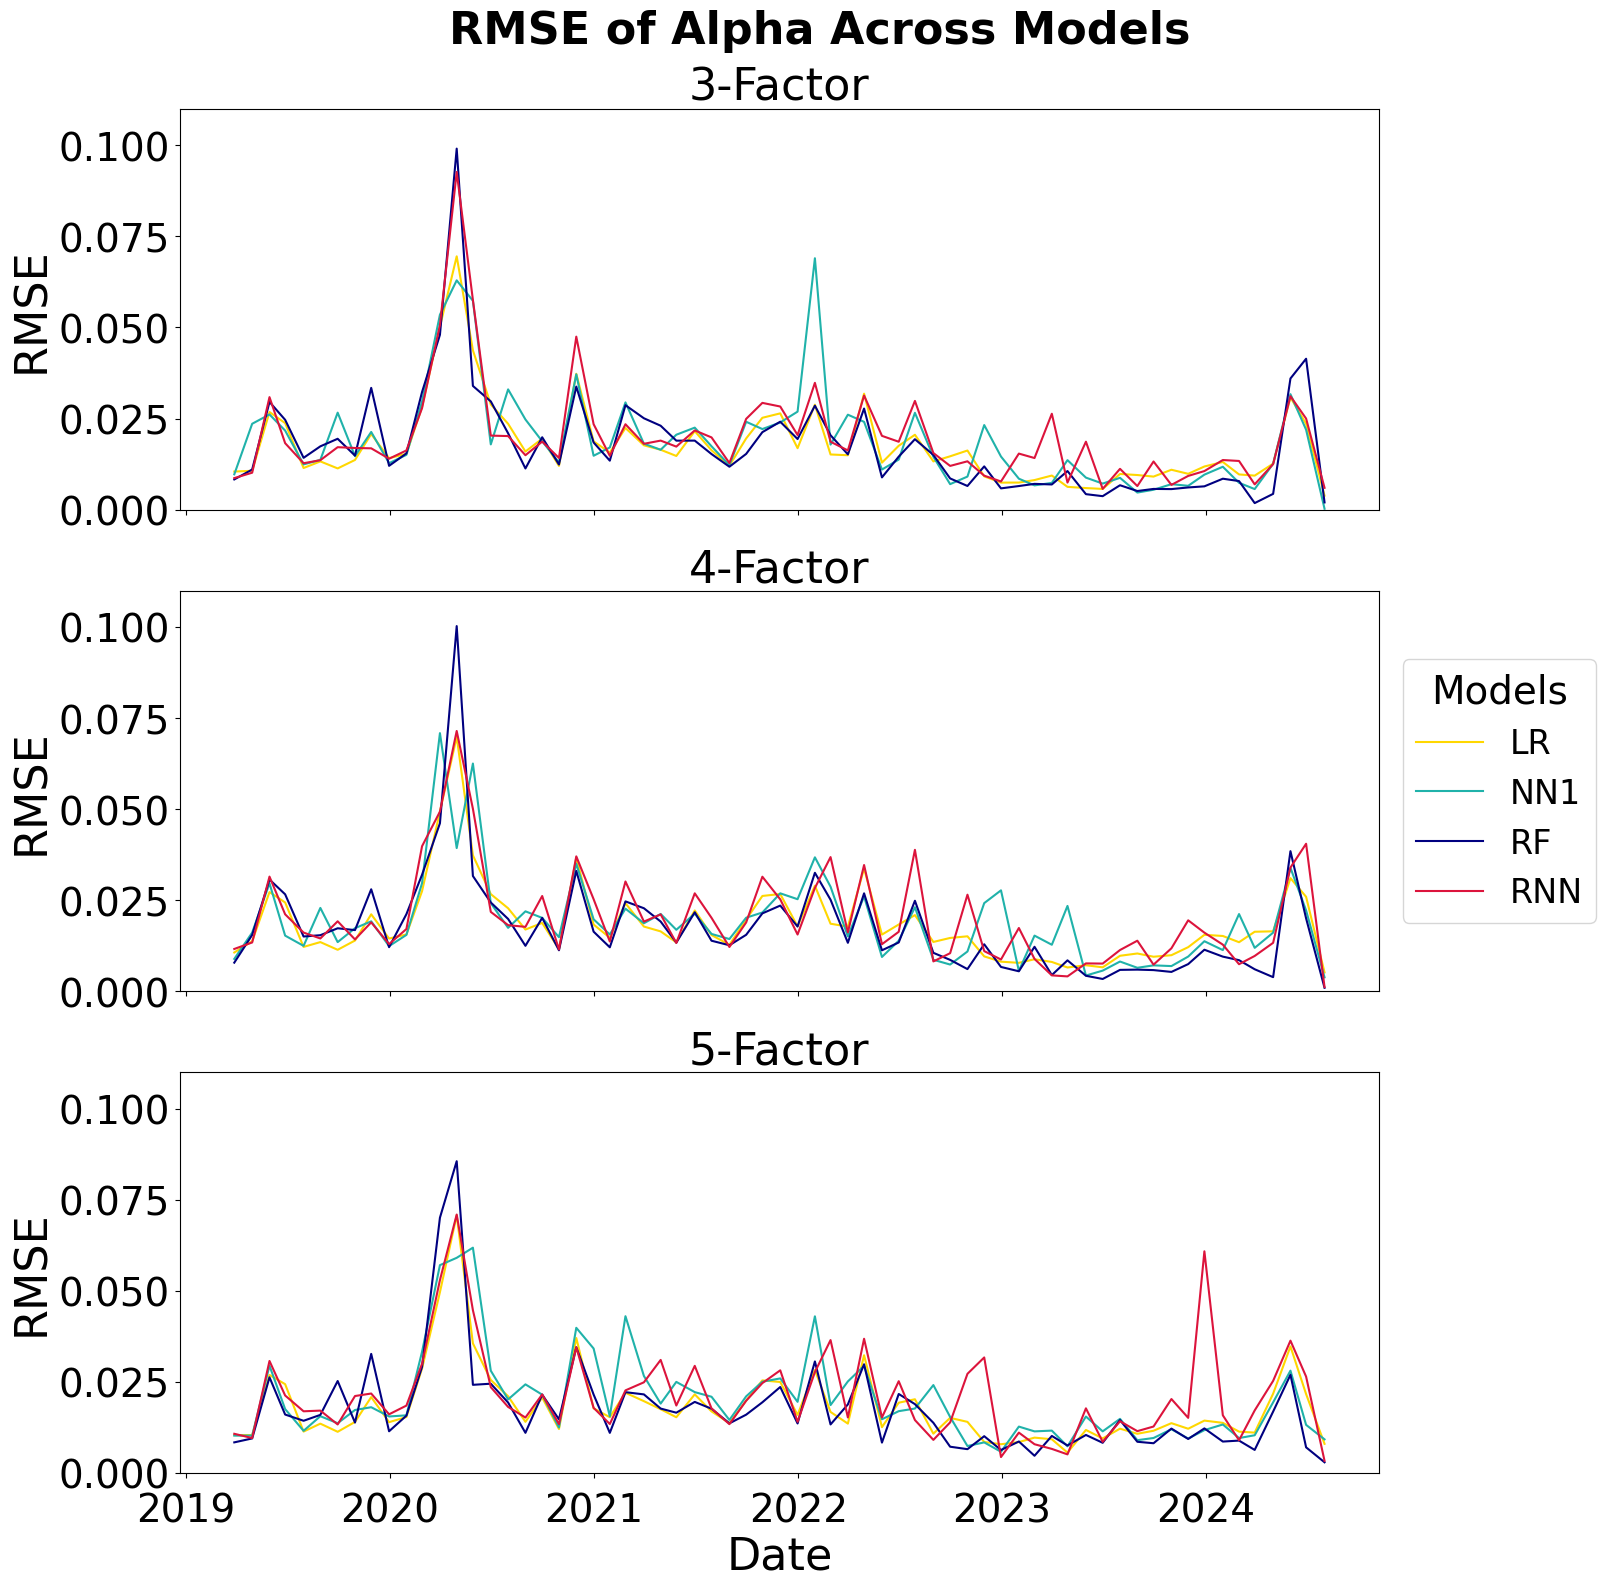

In [12]:
overall_plotter(all_metrics_results,'RMSE')

Plot 3: Cumulative Alpha Over Time

In [171]:
def plot_cumulative_alpha(df, outcome_var):
    label_mapping = {'ridge': 'Ridge', 'lstm': 'LSTM', 'rf': 'RF', 'pca': 'PCA'}
    color_list = {'Ridge': 'purple', 'LSTM': 'gold', 'PCA': 'lightseagreen', 'RF': 'navy'}
    
    fig, axis = plt.subplots(figsize=(12, 6))
    legend_handles = {}
    df_to_plot = df.copy()
    df_to_plot.index = pd.to_datetime(df_to_plot.index)
    df_to_plot = df_to_plot.sort_index()
    df_to_plot = df_to_plot.groupby(df_to_plot.index).mean()   # take mean for duplicated dates
    model_cols = [col for col in df_to_plot.columns if col != outcome_var]
    df_to_plot[outcome_var] = (df_to_plot[outcome_var] - df_to_plot[outcome_var].mean()) / df_to_plot[outcome_var].std()

    # Cumulative actual alpha
    df_to_plot['cumulative_action_based_alpha'] = df_to_plot[outcome_var].cumsum()
    
    # Compute cumulative action-based alpha
    for col in model_cols:
        df_to_plot[col] = (df_to_plot[col] - df_to_plot[col].mean()) / df_to_plot[col].std()
        # df_to_plot[f'cumulative_action_based_{col}'] = (df_to_plot[outcome_var] + df_to_plot[col] * df_to_plot[outcome_var]).cumsum()
        df_to_plot[f'cumulative_action_based_{col}'] = (df_to_plot[col] * df_to_plot[outcome_var]).cumsum()
    # return(df_to_plot)
    axis.plot(
        df_to_plot.index, df_to_plot['cumulative_action_based_alpha'], 
        label='Actual', color='black', linestyle='--', linewidth=2
    )

    # Plot cumulative action-based alpha
    for col in model_cols:
        cumulative_col = f'cumulative_action_based_{col}'
        model_name = col
        label = label_mapping.get(model_name, model_name)
        color = color_list.get(label, 'black')
        axis.plot(
            df_to_plot.index, df_to_plot[cumulative_col],
            label=label, color=color, linewidth=2
        )
        if label not in legend_handles:
            legend_handles[label] = axis.lines[-1]

    # Formatting the plot
    axis.set_xlabel('Date', fontsize=20)
    axis.set_ylabel('Cumulative Alpha', fontsize=20)
    axis.grid(False)
    axis.legend().set_visible(True)
    axis.tick_params(axis='both', labelsize=18)
    # axis.set_ylim((-20, 40))

    # Show plot
    plt.tight_layout()
    plt.show()

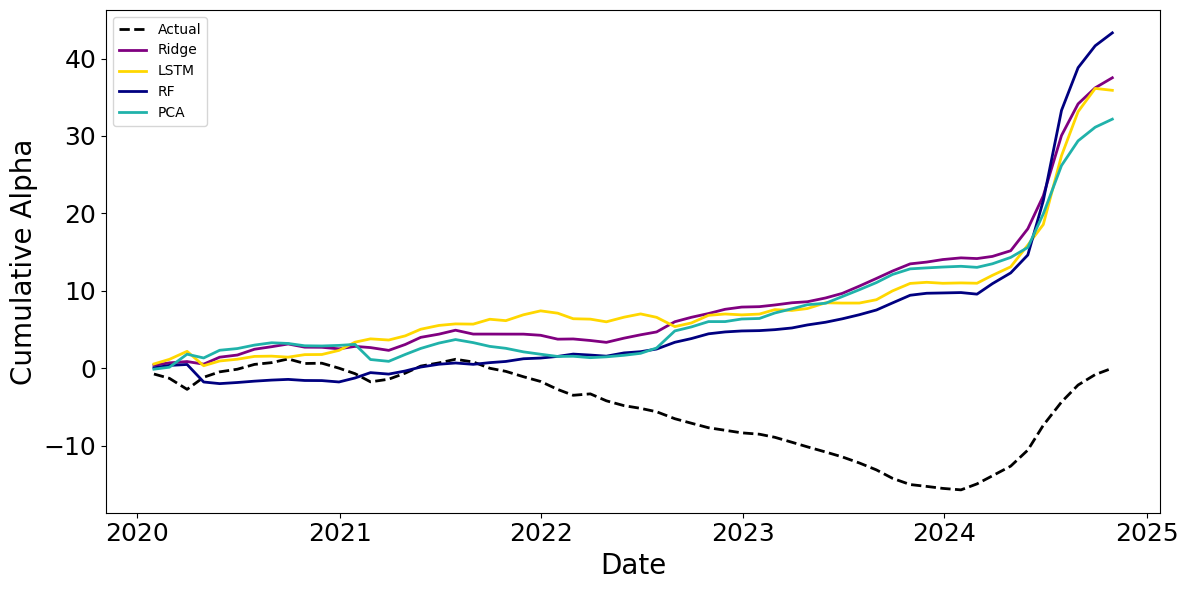

In [172]:
plot_cumulative_alpha(all_results_healthcare_clean, 'rolling_alpha_5f')

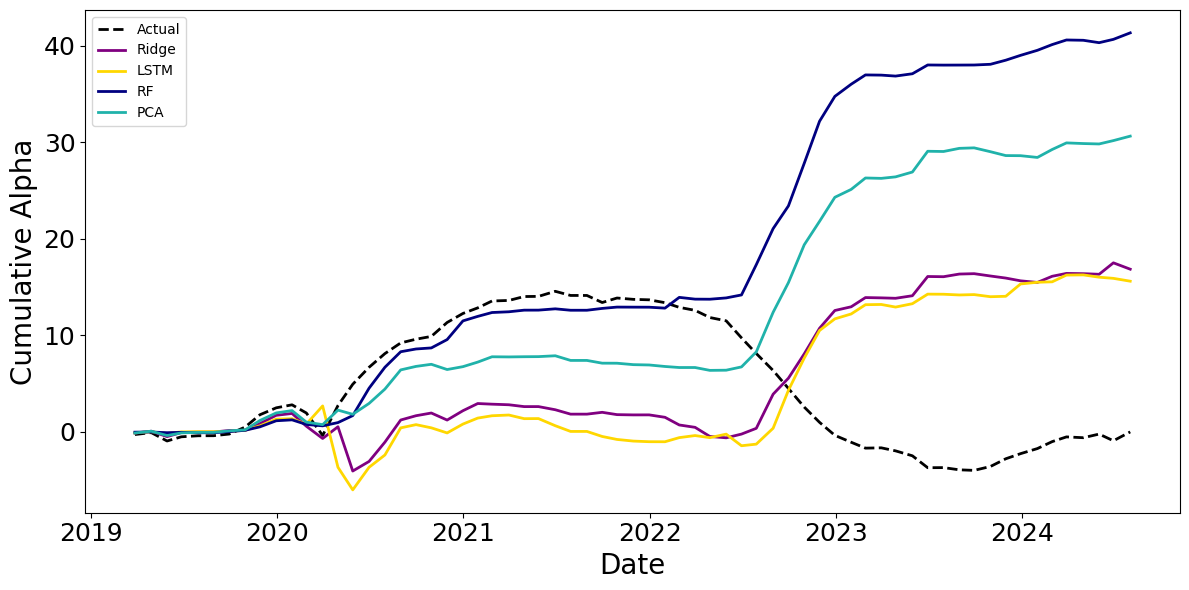

In [173]:
plot_cumulative_alpha(all_results_tech, 'rolling_alpha_5f')

In [15]:
def plot_cumulative_alpha(all_results):
    label_mapping = {'naive': 'Naive', 'linear': 'LR', 'ffnn': 'NN1', 'rf': 'RF', 'rnn': 'RNN'}
    color_list = {'Naive': 'purple', 'LR': 'gold', 'NN1': 'lightseagreen', 'RF': 'navy', 'RNN': 'crimson'}
    factor_list = {'rolling_alpha_3f': '3-Factor', 'rolling_alpha_4f': '4-Factor', 'rolling_alpha_5f': '5-Factor'}
    keys = list(all_results.keys())

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
    legend_handles = {}

    for i, alpha in enumerate(keys):
        axis = axes[i]
        df = all_results[alpha].copy()

        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        df = df.groupby(df.index).mean()   # take mean for duplicated dates
        model_cols = [col for col in df.columns if col != alpha]

        df['cumulative_rolling_alpha'] = df[alpha].cumsum()
        for col in model_cols:
            if col != alpha:
                df[f'cumulative_{col}'] = df[col].cumsum()

        axis.plot(
            df.index, df['cumulative_rolling_alpha'], label='Actual', color='black', linestyle='--', linewidth=2
        )
        legend_handles['Actual'] = axis.lines[-1]

        # Plot cumulative alpha for each model
        for col in df.columns:
            if col.startswith('cumulative_') and col != 'cumulative_rolling_alpha':
                model_name = col.replace('cumulative_', '').replace('_3f', '').replace('_4f', '').replace('_5f', '')
                label = label_mapping.get(model_name, model_name)
                color = color_list.get(label, 'black')
                axis.plot(
                    df.index, df[col],
                    label=label, color=color, linewidth=2
                )
                if label not in legend_handles:
                    legend_handles[label] = axis.lines[-1]

        # Formatting the plot
        axis.set_xlabel('Date')
        axis.set_ylabel('Cumulative Alpha')
        axis.set_title(f'Cumulative Alpha Over Time ({factor_list[alpha]})')
        axis.grid(False)
        axis.legend().set_visible(False)

    # Create legend on the right
    axes[3].axis('off')  # Remove axes
    axes[3].legend(
        legend_handles.values(), legend_handles.keys(),
        title='Models', loc='center', fontsize=14, title_fontsize=16
    )

    # Show plot
    plt.tight_layout()
    plt.show()


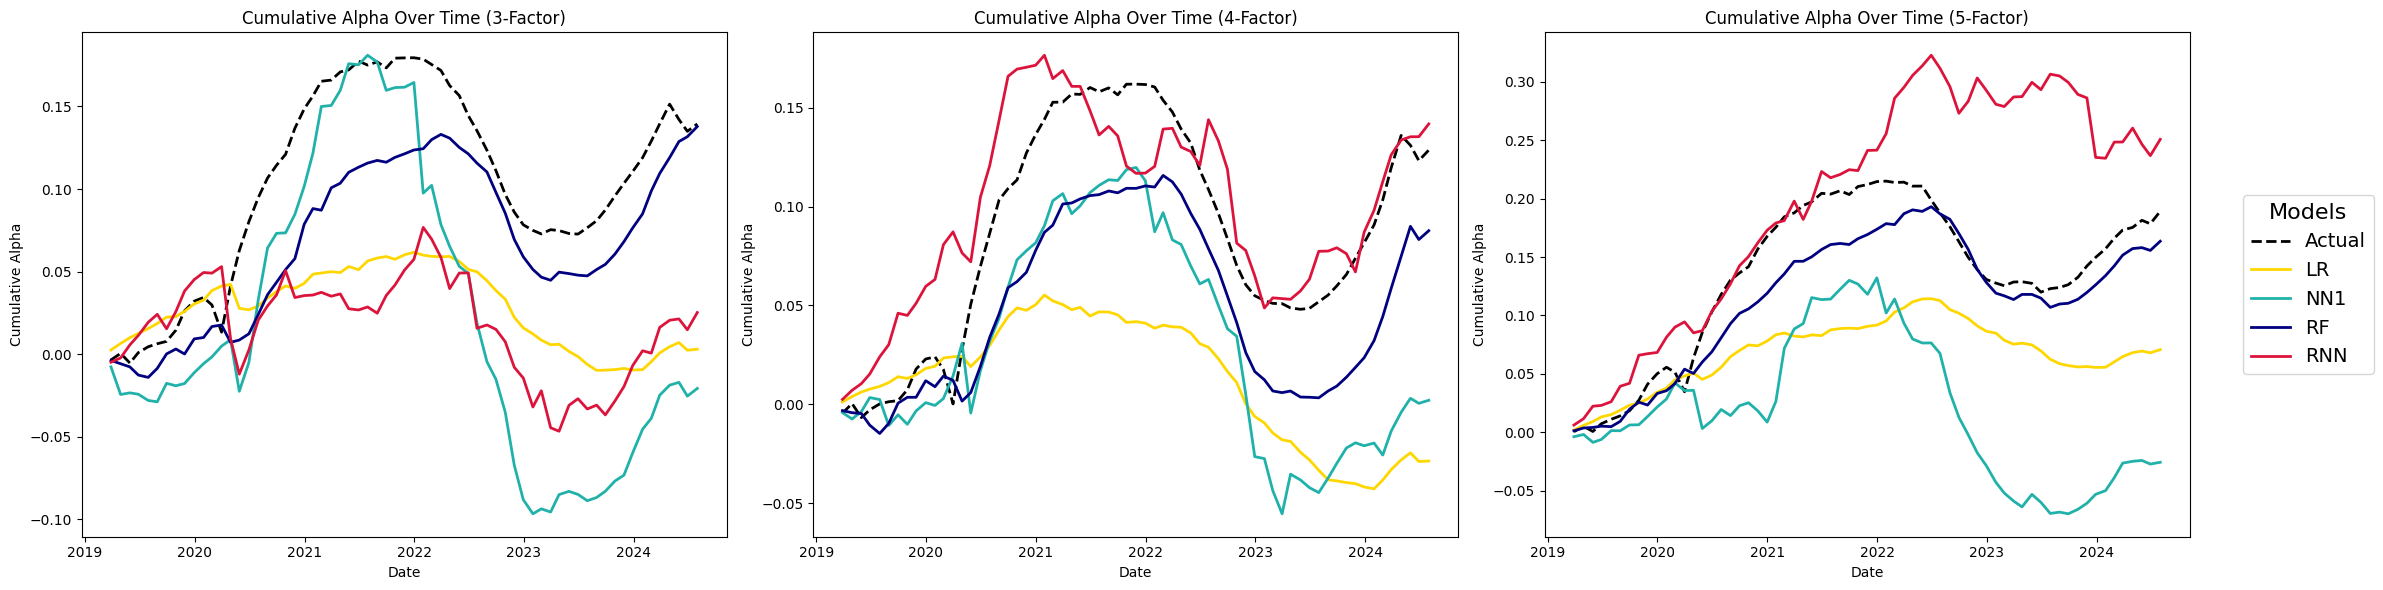

In [16]:
plot_cumulative_alpha(all_results)

Plot 4: Action-Based Cumulative Alpha Over Time

In [ ]:
def plot_action_based_cumulative_alpha(all_results):
    label_mapping = {'naive': 'Naive', 'linear': 'LR', 'ffnn': 'NN1', 'rf': 'RF', 'rnn': 'RNN'}
    color_list = {'Naive': 'purple', 'LR': 'gold', 'NN1': 'lightseagreen', 'RF': 'navy', 'RNN': 'crimson'}
    factor_list = {'rolling_alpha_3f': '3-Factor', 'rolling_alpha_4f': '4-Factor', 'rolling_alpha_5f': '5-Factor'}
    keys = list(all_results.keys())

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]}, sharey=True)
    legend_handles = {}

    for i, alpha in enumerate(keys):
        axis = axes[i]
        df = all_results[alpha].copy()

        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        df = df.groupby(df.index).mean()   # take mean for duplicated dates
        model_cols = [col for col in df.columns if col != alpha]

        df[alpha] = (df[alpha] - df[alpha].mean()) / df[alpha].std()

        # Cumulative actual alpha
        df['cumulative_action_based_alpha'] = df[alpha].cumsum()

        # Compute cumulative action-based alpha
        for col in model_cols:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
            df[f'cumulative_action_based_{col}'] = (df[col] * df[alpha]).cumsum()

        axis.plot(
            df.index, df['cumulative_action_based_alpha'], 
            label='Actual', color='black', linestyle='--', linewidth=2
        )

        legend_handles['Actual'] = axis.lines[-1]

        # Plot cumulative action-based alpha
        for col in model_cols:
            cumulative_col = f'cumulative_action_based_{col}'
            model_name = col.replace('_3f', '').replace('_4f', '').replace('_5f', '')
            label = label_mapping.get(model_name, model_name)
            color = color_list.get(label, 'black')
            axis.plot(
                df.index, df[cumulative_col],
                label=label, color=color, linewidth=2
            )
            if label not in legend_handles:
                legend_handles[label] = axis.lines[-1]

        # Formatting the plot
        axis.set_xlabel('Date', fontsize=20)
        axis.set_ylabel('Cumulative Alpha', fontsize=20)
        axis.set_title(f'Cumulative Alpha Over Time ({factor_list[alpha]})', fontsize=22)
        axis.grid(False)
        axis.legend().set_visible(False)
        axis.tick_params(axis='both', labelsize=18)
        axis.set_ylim((-20, 40))

    # Create legend on the right
    axes[3].axis('off')  # Remove axes
    axes[3].legend(
        legend_handles.values(), legend_handles.keys(),
        title='Models', loc='center', fontsize=18, title_fontsize=22
    )

    # Show plot
    plt.tight_layout()
    plt.show()


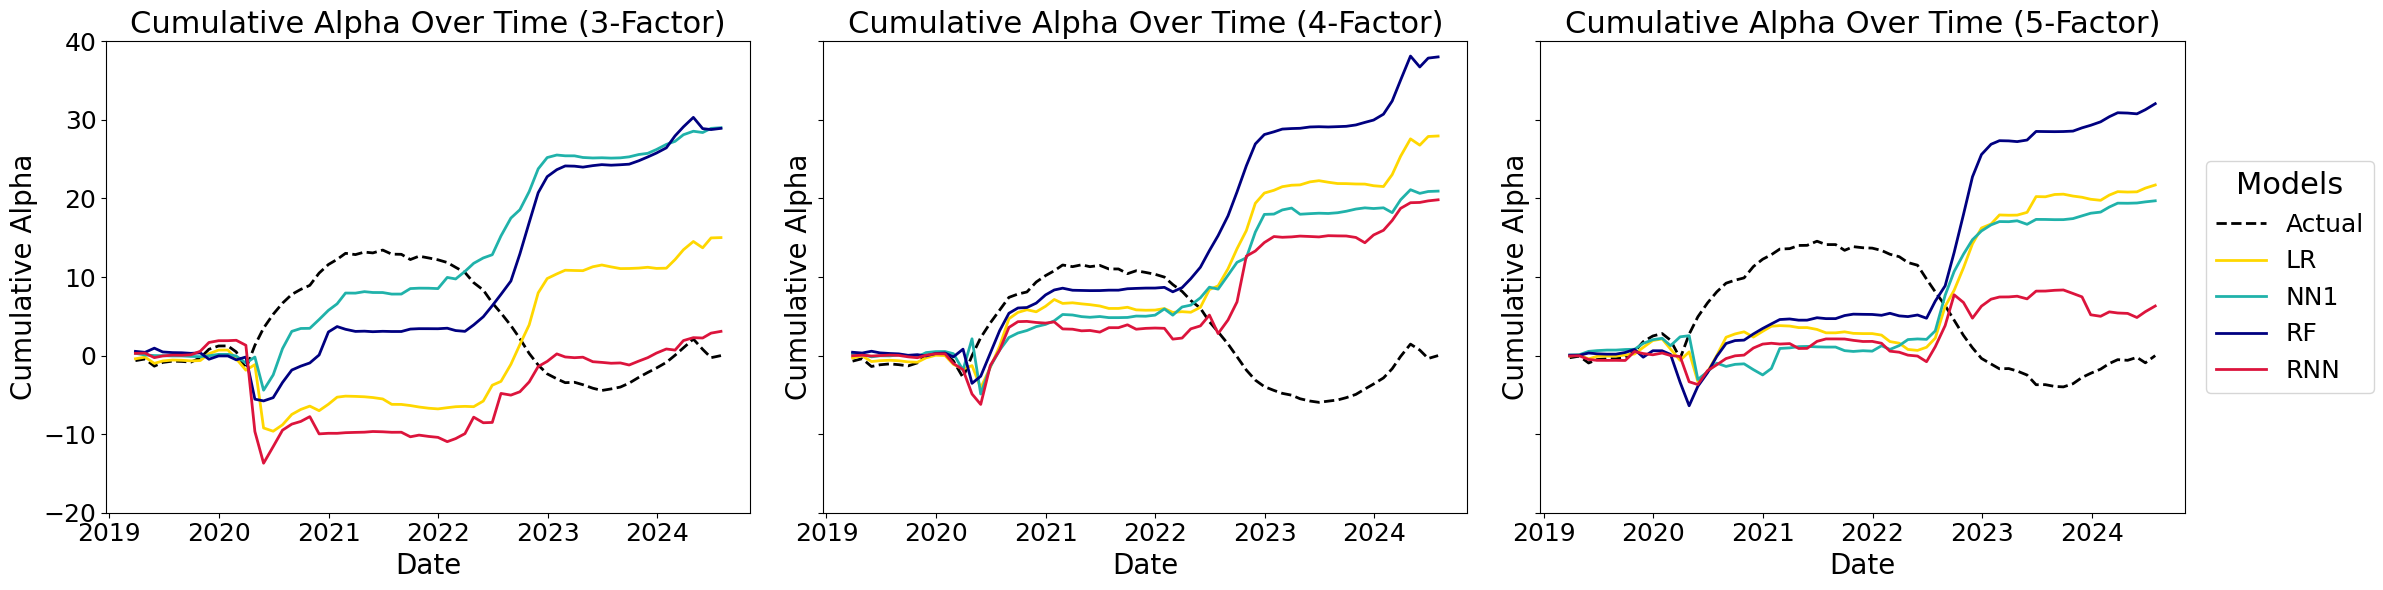

In [22]:
plot_action_based_cumulative_alpha(all_results)

In [28]:
##### Plot 3-, 4-, 5-factor models INDIVIDUALLY for SLIDES #####

def plot_action_based_cumulative_alpha(all_results):
    label_mapping = {'naive': 'Naive', 'linear': 'LR', 'ffnn': 'NN1', 'rf': 'RF', 'rnn': 'RNN'}
    color_list = {'Naive': 'purple', 'LR': 'gold', 'NN1': 'lightseagreen', 'RF': 'navy', 'RNN': 'crimson'}
    factor_list = {'rolling_alpha_3f': '3-Factor', 'rolling_alpha_4f': '4-Factor', 'rolling_alpha_5f': '5-Factor'}
    keys = list(all_results.keys())

    # fig, axes = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
    legend_handles = {}

    for i, alpha in enumerate(keys):
        fig, axis = plt.subplots(figsize=(8, 5))
        df = all_results[alpha].copy()

        df.index = pd.to_datetime(df.index)
        df = df.sort_index()
        df = df.groupby(df.index).mean()   # take mean for duplicated dates
        model_cols = [col for col in df.columns if col != alpha]

        df[alpha] = (df[alpha] - df[alpha].mean()) / df[alpha].std()

        # Cumulative actual alpha
        df['cumulative_action_based_alpha'] = df[alpha].cumsum()

        # Compute cumulative action-based alpha
        for col in model_cols:
            df[col] = (df[col] - df[col].mean()) / df[col].std()
            df[f'cumulative_action_based_{col}'] = (df[col] * df[alpha]).cumsum()

        axis.plot(
            df.index, df['cumulative_action_based_alpha'], 
            label='Actual', color='black', linestyle='--', linewidth=2
        )

        legend_handles['Actual'] = axis.lines[-1]

        # Plot cumulative action-based alpha
        for col in model_cols:
            cumulative_col = f'cumulative_action_based_{col}'
            model_name = col.replace('_3f', '').replace('_4f', '').replace('_5f', '')
            label = label_mapping.get(model_name, model_name)
            color = color_list.get(label, 'black')
            axis.plot(
                df.index, df[cumulative_col],
                label=label, color=color, linewidth=2
            )
            if label not in legend_handles:
                legend_handles[label] = axis.lines[-1]

        # Formatting the plot
        axis.set_xlabel('Date', fontsize=18)
        axis.set_ylabel('Cumulative Alpha', fontsize=18)
        axis.set_title(f'Action-Based Cumulative Alpha Over Time ({factor_list[alpha]})', fontsize=18)
        axis.grid(False)
        axis.legend().set_visible(True)
        axis.legend(fontsize=12)
        axis.tick_params(axis='both', labelsize=16)
        axis.set_ylim((-20, 40))

        plt.tight_layout()

    # # Create legend on the right
    # axes[3].axis('off')  # Remove axes
    # axes[3].legend(
    #     legend_handles.values(), legend_handles.keys(),
    #     title='Models', loc='center', fontsize=14, title_fontsize=16
    # )

    # # Show plot
    # plt.tight_layout()
    # plt.show()

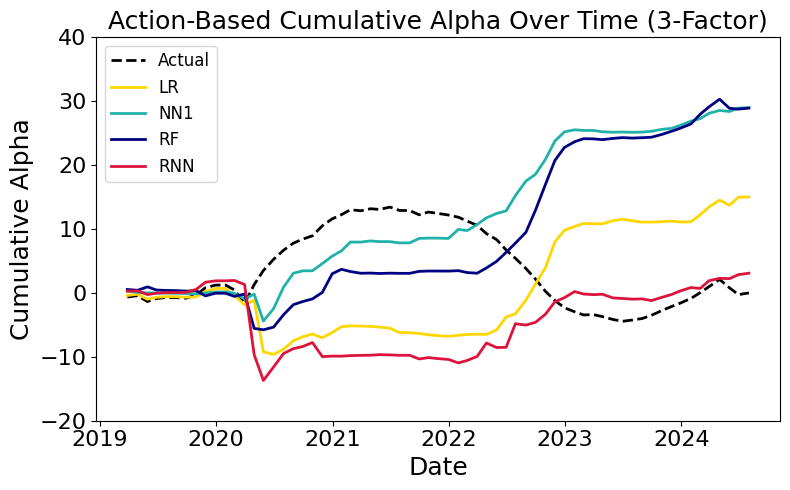

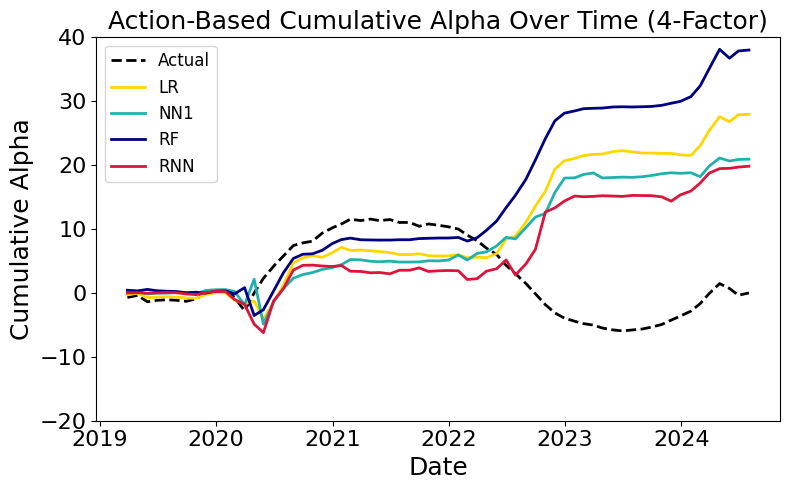

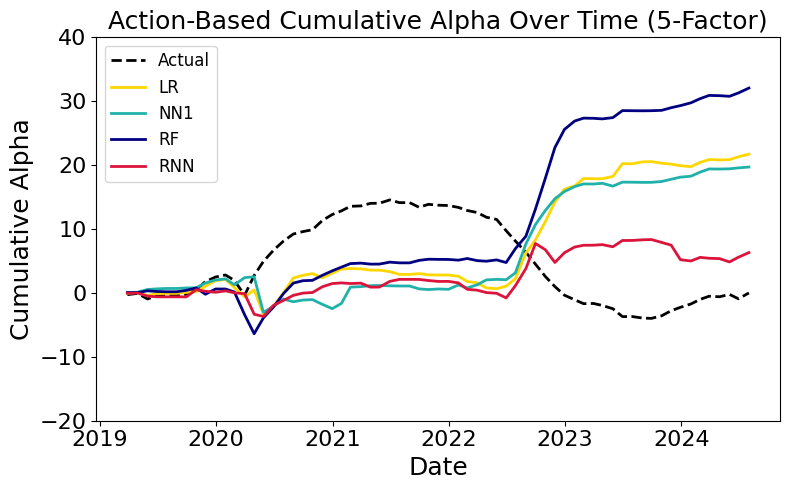

In [ ]:
plot_action_based_cumulative_alpha(all_results)

Plot 5: Cumulative Alpha for Top Decile Funds

In [25]:
# Loading in df
df = pd.read_csv("df_ff_factors_010225.csv")
df = df.drop(columns=["Unnamed: 0","crsp_portno"])
df = df.sort_values(by='date')
df['date'] = pd.to_datetime(df['date']) 

# Alpha model training results (all models)
y_3f = pd.read_csv("results_alpha/all_3f_alpha.csv")
y_4f = pd.read_csv("results_alpha/all_4f_alpha.csv")
y_5f = pd.read_csv("results_alpha/all_5f_alpha.csv")

In [ ]:
# Combining results df with fundno and dates
rolling_alphas = ["rolling_alpha_3f", "rolling_alpha_4f", "rolling_alpha_5f"]
results = [y_3f, y_4f, y_5f]
df_with_id = {}

for i in range(0, len(rolling_alphas)):
    factor = rolling_alphas[i][-2:]

    dataset = df[["crsp_fundno", "date", rolling_alphas[i]]]
    merged_df = pd.merge(results[i], dataset, how="left", on=rolling_alphas[i])
    merged_df = merged_df.rename(columns={'naive': f'naive_{factor}'})
    
    merged_df = merged_df.set_index('date')
    feature_cols = [col for col in merged_df_no_id.columns if col not in [rolling_alphas[i]]]

    # Using a dictionary to store the df for different factor models
    df_with_id[rolling_alphas[i]] = merged_df


In [27]:
def top_decile_funds(results, alpha, top_n=10):
    fund_perf = results.groupby('crsp_fundno')[alpha].mean()
    top_funds = fund_perf.sort_values(ascending=False).head(top_n).index
    filtered = results[results['crsp_fundno'].isin(top_funds)]
    return filtered

def top_funds_cumulative(results, rolling_alphas):
    cumulative_results = {}

    for alpha in rolling_alphas:
        df = results[alpha]
        filtered = top_decile_funds(df, alpha, top_n=10)

        cumul_model_results = {}
        model_cols = [col for col in filtered.columns if col not in ['crsp_fundno', alpha, 'date']]
        for model in model_cols:
            model_grouped = filtered.groupby('date')[model].sum()
            cumul_model_results[model] = model_grouped.cumsum()

        cumulative_results[alpha] = cumul_model_results

    return cumulative_results

In [28]:
def plot_top_funds(cumulative_results):
    label_mapping = {'naive': 'Naive', 'linear': 'LR', 'ffnn': 'NN1', 'rf': 'RF', 'rnn': 'RNN'}
    color_list = {'Naive': 'crimson', 'LR': 'gold', 'NN1': 'lightseagreen', 'RF': 'navy', 'RNN': 'purple'}
    factor_list = {'rolling_alpha_3f': '3-Factor', 'rolling_alpha_4f': '4-Factor', 'rolling_alpha_5f': '5-Factor'}
    keys = list(cumulative_results.keys())

    fig, axes = plt.subplots(1, 4, figsize=(24, 6), gridspec_kw={'width_ratios': [1, 1, 1, 0.1]})
    legend_handles = {}

    for i, factor in enumerate(keys):
        axis = axes[i]
        model_results = cumulative_results[factor]  # Get cumulative alpha per model

        # Plot cumulative alpha for each model
        for model, cumulative_alpha in model_results.items():
            model_name = model.replace('_3f', '').replace('_4f', '').replace('_5f', '')
            label = label_mapping.get(model_name, model_name)
            color = color_list.get(label, 'black')
            axis.plot(
                cumulative_alpha.index, cumulative_alpha,
                label=label, color=color, linewidth=2
            )
            if label not in legend_handles:  # Store for legend
                legend_handles[label] = axis.lines[-1]

        # Formatting
        axis.set_xlabel('Date', fontsize=14)
        axis.set_ylabel('Cumulative Alpha', fontsize=14)
        axis.set_title(f'Cumulative Alpha of Top Decile Funds Over Time ({factor_list.get(factor, factor)})')
        axis.grid(False)
        axis.legend().set_visible(False)

    # Create a shared legend in the fourth subplot
    axes[3].axis('off')  # Remove axes
    axes[3].legend(
        legend_handles.values(), legend_handles.keys(),
        title='Models', loc='center', fontsize=14, title_fontsize=16
    )

    # Show the plot
    plt.tight_layout()
    plt.show()
    

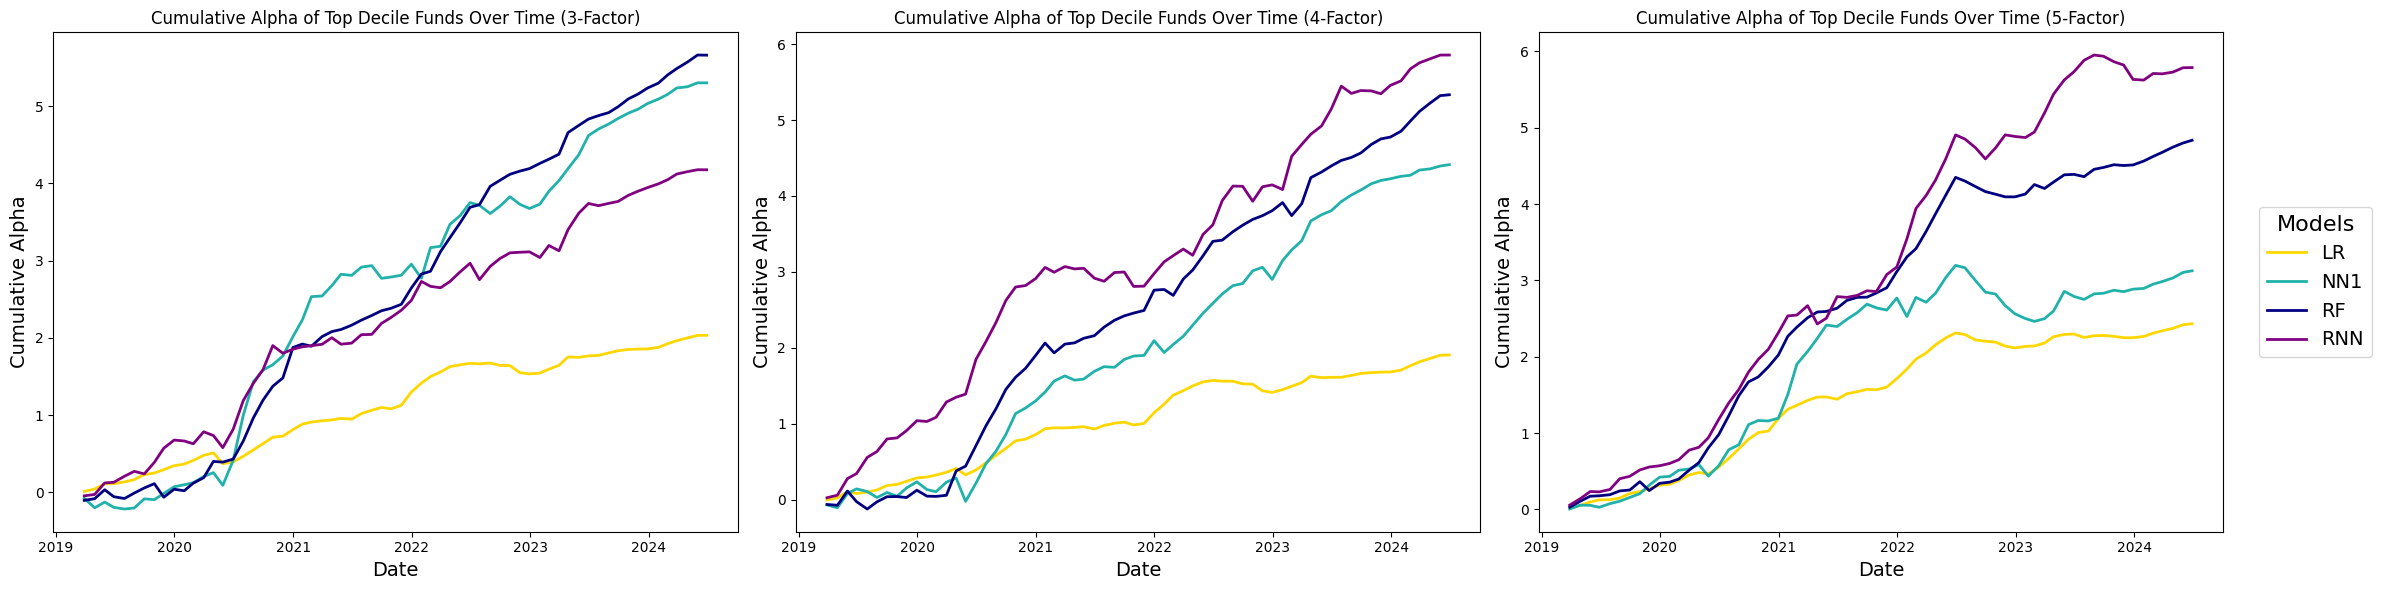

In [30]:
cumulative_results = top_funds_cumulative(df_with_id, rolling_alphas)
plot_top_funds(cumulative_results)